In [1]:
%load_ext autoreload
%autoreload 2
%cd -q ../scripts/
from default_param import *
%matplotlib inline

#  figure 6: MotionReversal




## running MotionReversal


In [2]:
%%writefile experiment_MotionReversal.py
import MotionParticles as mp
gen_dot = mp.generate_dot
import numpy as np
import os
from default_param import *

image = {}
experiment = 'MotionReversal'

stimulus_tag = 'dot'
im_arg = stim_args[0]
im_arg.update(reversal=True)

# generating the movie
image[stimulus_tag] = {}
image[stimulus_tag]['args'] = im_arg
image[stimulus_tag]['args'].update(reversal=True)

image[stimulus_tag]['im'] = gen_dot(N_X=N_X, N_Y=N_Y, N_frame=N_frame, **image[stimulus_tag]['args'])

# the rest is similar
mp.anim_save(image[stimulus_tag]['im'], os.path.join(mp.figpath, experiment + '-anim-' + stimulus_tag))
image[stimulus_tag]['result'] = {}

# running PX and MBP with 2 different latencies
for D_x, D_V, v_prior, label in zip([mp.D_x, PBP_D_x], [mp.D_V, PBP_D_V], [mp.v_prior, PBP_prior], ['MBP', 'PBP']):
    figname = os.path.join(mp.figpath, experiment + '-' + stimulus_tag + '-' + label)

    image[stimulus_tag]['result'][label] = {}
    image[stimulus_tag]['args'].update(D_V=D_V, D_x=D_x, v_prior=v_prior)
    _  = mp.figure_image_variable(
            figname, 
            N_X, N_Y, N_frame, gen_dot, do_figure=True, do_video=False, order=None, N_quant_X=N_quant_X, N_quant_Y=N_quant_Y,
            fixed_args=image[stimulus_tag]['args'], latency=latencies)
    for latency in latencies:
        try:
            matname = mp.make_figname(figname, {'latency': latency}).replace(mp.figpath, mp.matpath) + '.npy'
            image[stimulus_tag]['result'][label][latency] = np.load(matname)
        except:
            print('no result yet for ', matname)

Writing experiment_MotionReversal.py


In [3]:
%run experiment_MotionReversal.py

Saving sequence results/MotionReversal-anim-dot.mp4


/usr/local/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}


## x-t plot of the stimulation

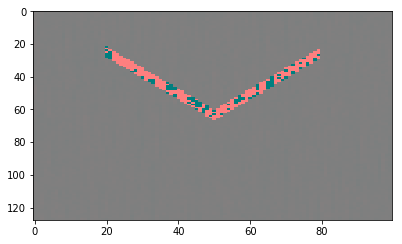

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
__temp = np.zeros((N_X, N_frame, 3))
__temp[:, :, 0] = image[stimulus_tag]['im'][:, N_Y//2, :]
ax.imshow(.5*__temp+.5, interpolation='nearest',  aspect='auto', vmin=-1., vmax=1.)


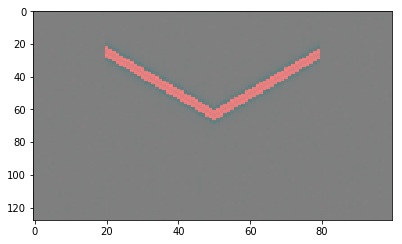

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
__temp = np.zeros((N_X, N_frame, 3))
white = mp.whitening(image[stimulus_tag]['im'])
white /= np.abs(white).max()
__temp[:, :, 0] = white[:, N_Y//2, :]
ax.imshow(.5*__temp+.5, interpolation='nearest',  aspect='auto', vmin=-1., vmax=1.)


## x-t plot of the results

First showing the histogram of detected positions for both stimuli:

In [6]:
particles = image[stimulus_tag]['result']['MBP'][10].copy()
v_hist, x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
v_hist /= np.sum(v_hist, axis=0)
x_middle = .5*(x_edges[1:] + x_edges[:-1])

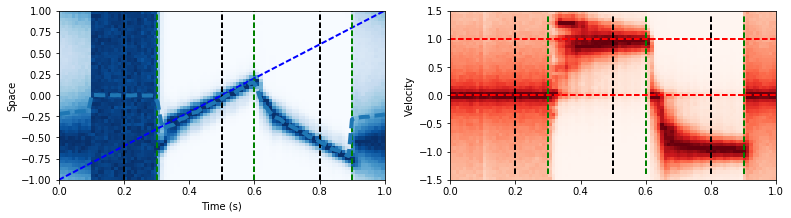

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(2*fig_width, fig_width /2))
fig, axs = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, fig=fig, a=axs)
time = np.linspace(0, 1, N_frame)
average_pos = np.sum(v_hist*x_middle[:, np.newaxis], axis=0)
axs[0].plot(time, average_pos, lw=4, ls='--')

Now showing the spatial histogram for both stimuli at this moment:

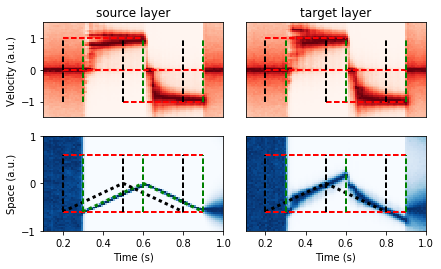

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_width/1.618))
for ax in axs.ravel(): 
    ax.axis(c='b', lw=2, axisbg='w')
    ax.set_facecolor('w')
    
stimulus_tag == 'flash'
stimulus_tag = 'dot'
v_hist = {}

for i, (latency, dlabel, length) in enumerate(zip(latencies, ['source layer', 'target layer'], [.6, .6])):

    particles = image[stimulus_tag]['result']['MBP'][latency].copy()
    if latency is 0:
        particles = np.roll(particles, 10, axis=-1)

    v_hist[latency], x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
    v_hist[latency] /= np.sum(v_hist[latency])
    v_hist[latency] /= v_hist[latency].max(axis=0)[np.newaxis, :]
    #v_hist[latency] /= np.sum(v_hist[latency])

    Time, X = np.meshgrid(np.linspace(0, 1, N_frame), x_edges)
    axs[1][i].pcolormesh(Time[:, 10:], X[:, 10:], v_hist[latency][:, 10:], cmap=plt.cm.Blues, vmin=0., vmax=v_hist[latency].max())#, edgecolor=(1, 1, 1, 1.))

    v_hist_u = np.zeros((N_quant_X, N_frame))
    u_edges = np.linspace(-1.5, 1.5, N_quant_X+1)
    for t in range(N_frame) :
        u = particles[2, :, t]
        weights = particles[4,  :, t]
        v_hist_u[:, t], u_edges_ = np.histogram(u, u_edges, normed=False, weights=weights)
    
    v_hist_u /= v_hist_u.max(axis=0)[np.newaxis, :]
    
    Time, U = np.meshgrid(np.linspace(0, 1, N_frame), u_edges_)
    axs[0][i].pcolormesh(Time[:, 10:], U[:, 10:], v_hist_u[:, 10:], cmap=plt.cm.Reds, vmin=0., vmax=v_hist_u.max())#, edgecolor=(1, 1, 1, 1.))
    axs[1][i].plot([.2, .5], [-.6, .0], 'k:', lw=3)
    if i==0: axs[1][i].plot([.3, .6], [-.6, .0], 'g:', lw=3)
    axs[1][i].plot([.5, .8], [0., -.6], 'k:', lw=3)
    if i==0: axs[1][i].plot([.6, .9], [0., -.6], 'g:', lw=3)


    axs[1][i].plot([.2, length+.3], [-.6, -.6], 'r--', lw=2)
    axs[1][i].plot([.2, length+.3], [.6, .6], 'r--', lw=2)
    axs[0][i].plot([.2, length+.3], [0., 0.], 'r--', lw=2)
    axs[0][i].plot([.2, length], [1., 1.], 'r--', lw=2)
    axs[0][i].plot([.5, length+.3], [-1., -1.], 'r--', lw=2)
    axs[0][i].set_title(dlabel)
    
    for k, vmin, vmax in zip(range(2), [-1., -.6], [1., .6]):
        for c, xs in zip(['k', 'g'], [[.2, .5, .8], [.3, .6, .9]]):
            for x in xs:
                #if i==0 or c=='k': 
                axs[k][i].plot([x, x], [vmin, vmax], ls='--', lw=2, c=c)
                
    for j in [0, 1]:
        axs[j][i].locator_params(axis = 'x', nbins = 6)
        axs[j][i].locator_params(axis = 'y', nbins = 3-2*(j-1)) # HACK
        axs[j][i].axis('tight')
                   
    plt.setp(axs[0][i], xticks=[])
    plt.setp(axs[0][1], yticks=[])
    plt.setp(axs[1][1], yticks=[])

axs[1][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('Velocity (a.u.)')
axs[1][0].set_ylabel('Space (a.u.)')
axs[1][1].set_xlabel('Time (s)')
plt.tight_layout()
for ext in FORMATS: fig.savefig(os.path.join('../figures/', 'FLE_MotionReversal_MBP' + ext))

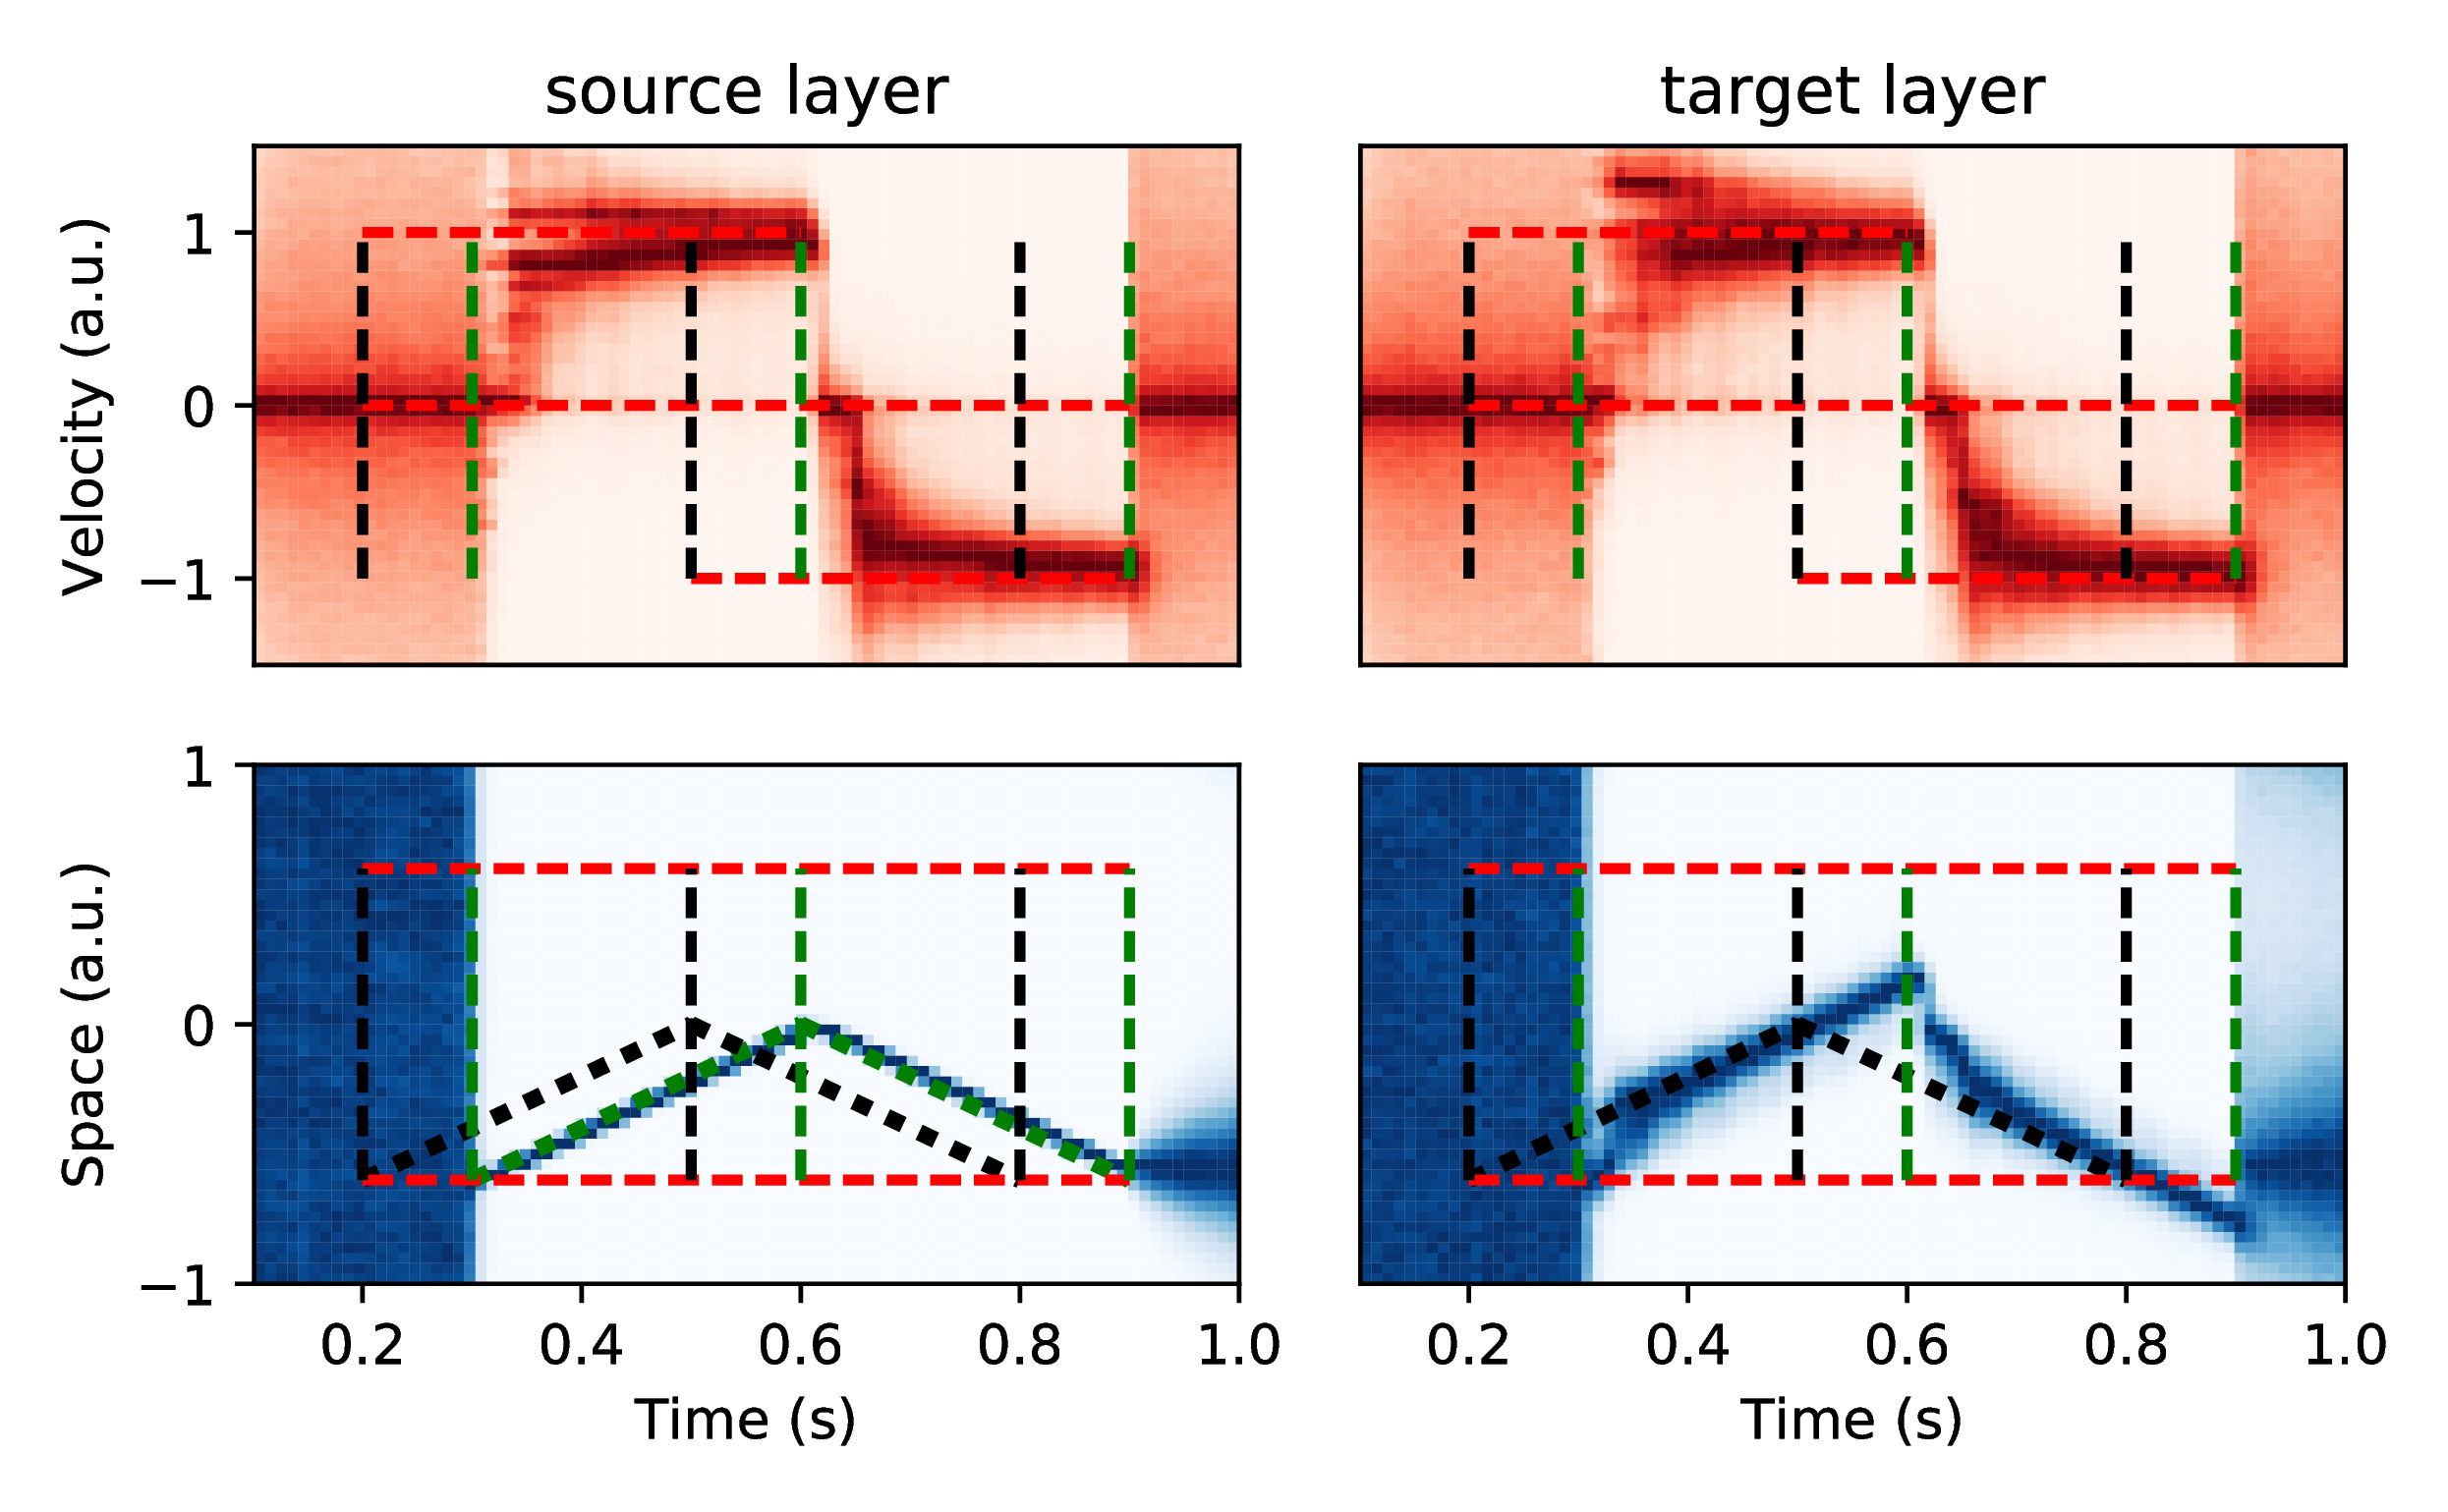

In [9]:
!convert -density 400 ../figures/FLE_MotionReversal_MBP.pdf ../figures/FLE_MotionReversal_MBP.jpg
!convert  -density 600 -units pixelsperinch -flatten  -compress lzw  -depth 8 ../figures/FLE_MotionReversal_MBP.pdf ../figures/FLE_MotionReversal_MBP.tiff

from IPython.display import Image
Image('../figures/FLE_MotionReversal_MBP.jpg')

## smoothing

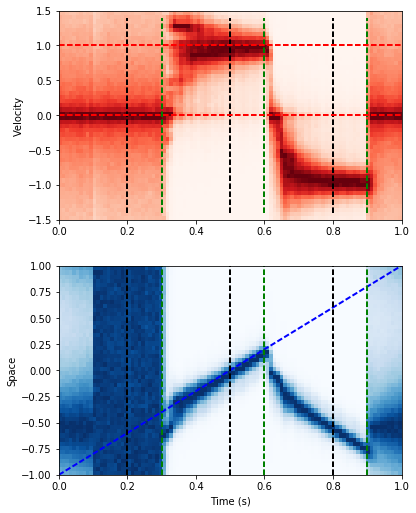

In [10]:
particles = image['dot']['result']['MBP'][10].copy()  
fig, axs = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1)#, fig=fig, a=axs[i])

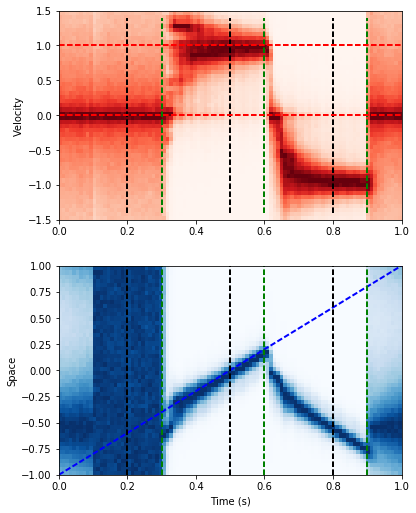

In [11]:
particles = image['dot']['result']['MBP'][10].copy()
#particles[2:4, :, :] = np.roll(particles[2:4, :, :], -10, axis=2)
fig, axs = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1)#, fig=fig, a=axs[i])

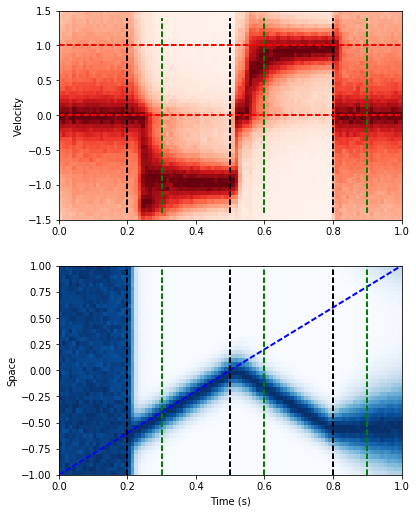

In [12]:
particles = image['dot']['result']['MBP'][10].copy()
subjective_latency = 10
particles[0:2, :, :] = np.roll(particles[0:2, :, :], -subjective_latency, axis=2)
particles[2:4, :, :] = -np.roll(particles[2:4, :, :], -subjective_latency, axis=2)
particles= mp.prediction(particles, N_frame/subjective_latency, D_V=mp.D_V, D_x=mp.D_x, width=mp.width, v_prior=mp.v_prior)
fig, axs = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1)

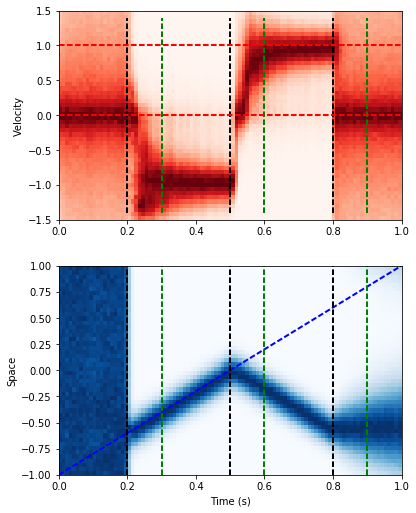

In [13]:
particles = image['dot']['result']['MBP'][10].copy()
subjective_latency = 10
particles[2:4, :, :] = -particles[2:4, :, :]
particles= mp.prediction(particles, N_frame/subjective_latency, D_V=mp.D_V, D_x=mp.D_x, width=mp.width, v_prior=mp.v_prior)
particles = np.roll(particles, -subjective_latency, axis=2)
fig, axs = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1)

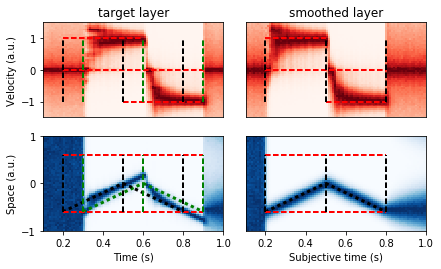

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_width/1.618))
for ax in axs.ravel(): 
    ax.axis(c='b', lw=2, axisbg='w')
    ax.set_facecolor('w')
    
stimulus_tag = 'dot'
v_hist = {}
latencies = [10, -10]
subjective_latency = 10
for i, (latency, dlabel, length) in enumerate(zip(latencies, ['target layer', 'smoothed layer'], [.6, .5])):
    particles = image[stimulus_tag]['result']['MBP'][abs(latency)].copy()
    if latency == -10:
        particles[2:4, :, :] = -particles[2:4, :, :]
        particles = mp.prediction(particles, N_frame/subjective_latency, D_V=mp.D_V, D_x=mp.D_x, width=mp.width, v_prior=mp.v_prior)
        particles = np.roll(particles, -subjective_latency, axis=2)
        particles[2:4, :, :] = -particles[2:4, :, :]

    v_hist[latency], x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
    v_hist[latency] /= np.sum(v_hist[latency])
    v_hist[latency] /= v_hist[latency].max(axis=0)[np.newaxis, :]

    Time, X = np.meshgrid(np.linspace(0, 1, N_frame), x_edges)
    axs[1][i].pcolormesh(Time[:, 10:], X[:, 10:], v_hist[latency][:, 10:], cmap=plt.cm.Blues, vmin=0., vmax=v_hist[latency].max())#, edgecolor=(1, 1, 1, 1.))

    v_hist_u = np.zeros((N_quant_X, N_frame))
    u_edges = np.linspace(-1.5, 1.5, N_quant_X+1)
    for t in range(N_frame) :
        u = particles[2, :, t]
        weights = particles[4,  :, t]
        v_hist_u[:, t], u_edges_ = np.histogram(u, u_edges, normed=False, weights=weights)
    
    v_hist_u /= v_hist_u.max(axis=0)[np.newaxis, :]
    
    Time, U = np.meshgrid(np.linspace(0, 1, N_frame), u_edges_)
    axs[0][i].pcolormesh(Time[:, 10:], U[:, 10:], v_hist_u[:, 10:], cmap=plt.cm.Reds, vmin=0., vmax=v_hist_u.max())#, edgecolor=(1, 1, 1, 1.))
    axs[1][i].plot([.2, .5], [-.6, .0], 'k:', lw=3)
    if i==0: axs[1][i].plot([.3, .6], [-.6, .0], 'g:', lw=3)
    axs[1][i].plot([.5, .8], [0., -.6], 'k:', lw=3)
    if i==0: axs[1][i].plot([.6, .9], [0., -.6], 'g:', lw=3)

    axs[1][i].plot([.2, length+.3], [-.6, -.6], 'r--', lw=2)
    axs[1][i].plot([.2, length+.3], [.6, .6], 'r--', lw=2)
    axs[0][i].plot([.2, length+.3], [0., 0.], 'r--', lw=2)
    axs[0][i].plot([.2, length], [1., 1.], 'r--', lw=2)
    axs[0][i].plot([.5, length+.3], [-1., -1.], 'r--', lw=2)
    axs[0][i].set_title(dlabel)
    
    for k, vmin, vmax in zip(range(2), [-1., -.6], [1., .6]):
        for c, xs in zip(['k', 'g'], [[.2, .5, .8], [.3, .6, .9]]):
            for x in xs:
                if i==0 or c=='k': axs[k][i].plot([x, x], [vmin, vmax], ls='--', lw=2, c=c)
                
    for j in [0, 1]:
        axs[j][i].locator_params(axis = 'x', nbins = 6)
        axs[j][i].locator_params(axis = 'y', nbins = 3-2*(j-1)) # HACK
        axs[j][i].axis('tight')
                   
    plt.setp(axs[0][i], xticks=[])
    plt.setp(axs[0][1], yticks=[])
    plt.setp(axs[1][1], yticks=[])

axs[1][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('Velocity (a.u.)')
axs[1][0].set_ylabel('Space (a.u.)')
axs[1][1].set_xlabel('Subjective time (s)')
plt.tight_layout()
for ext in FORMATS: fig.savefig(os.path.join('../figures/', 'FLE_MotionReversal' + ext))

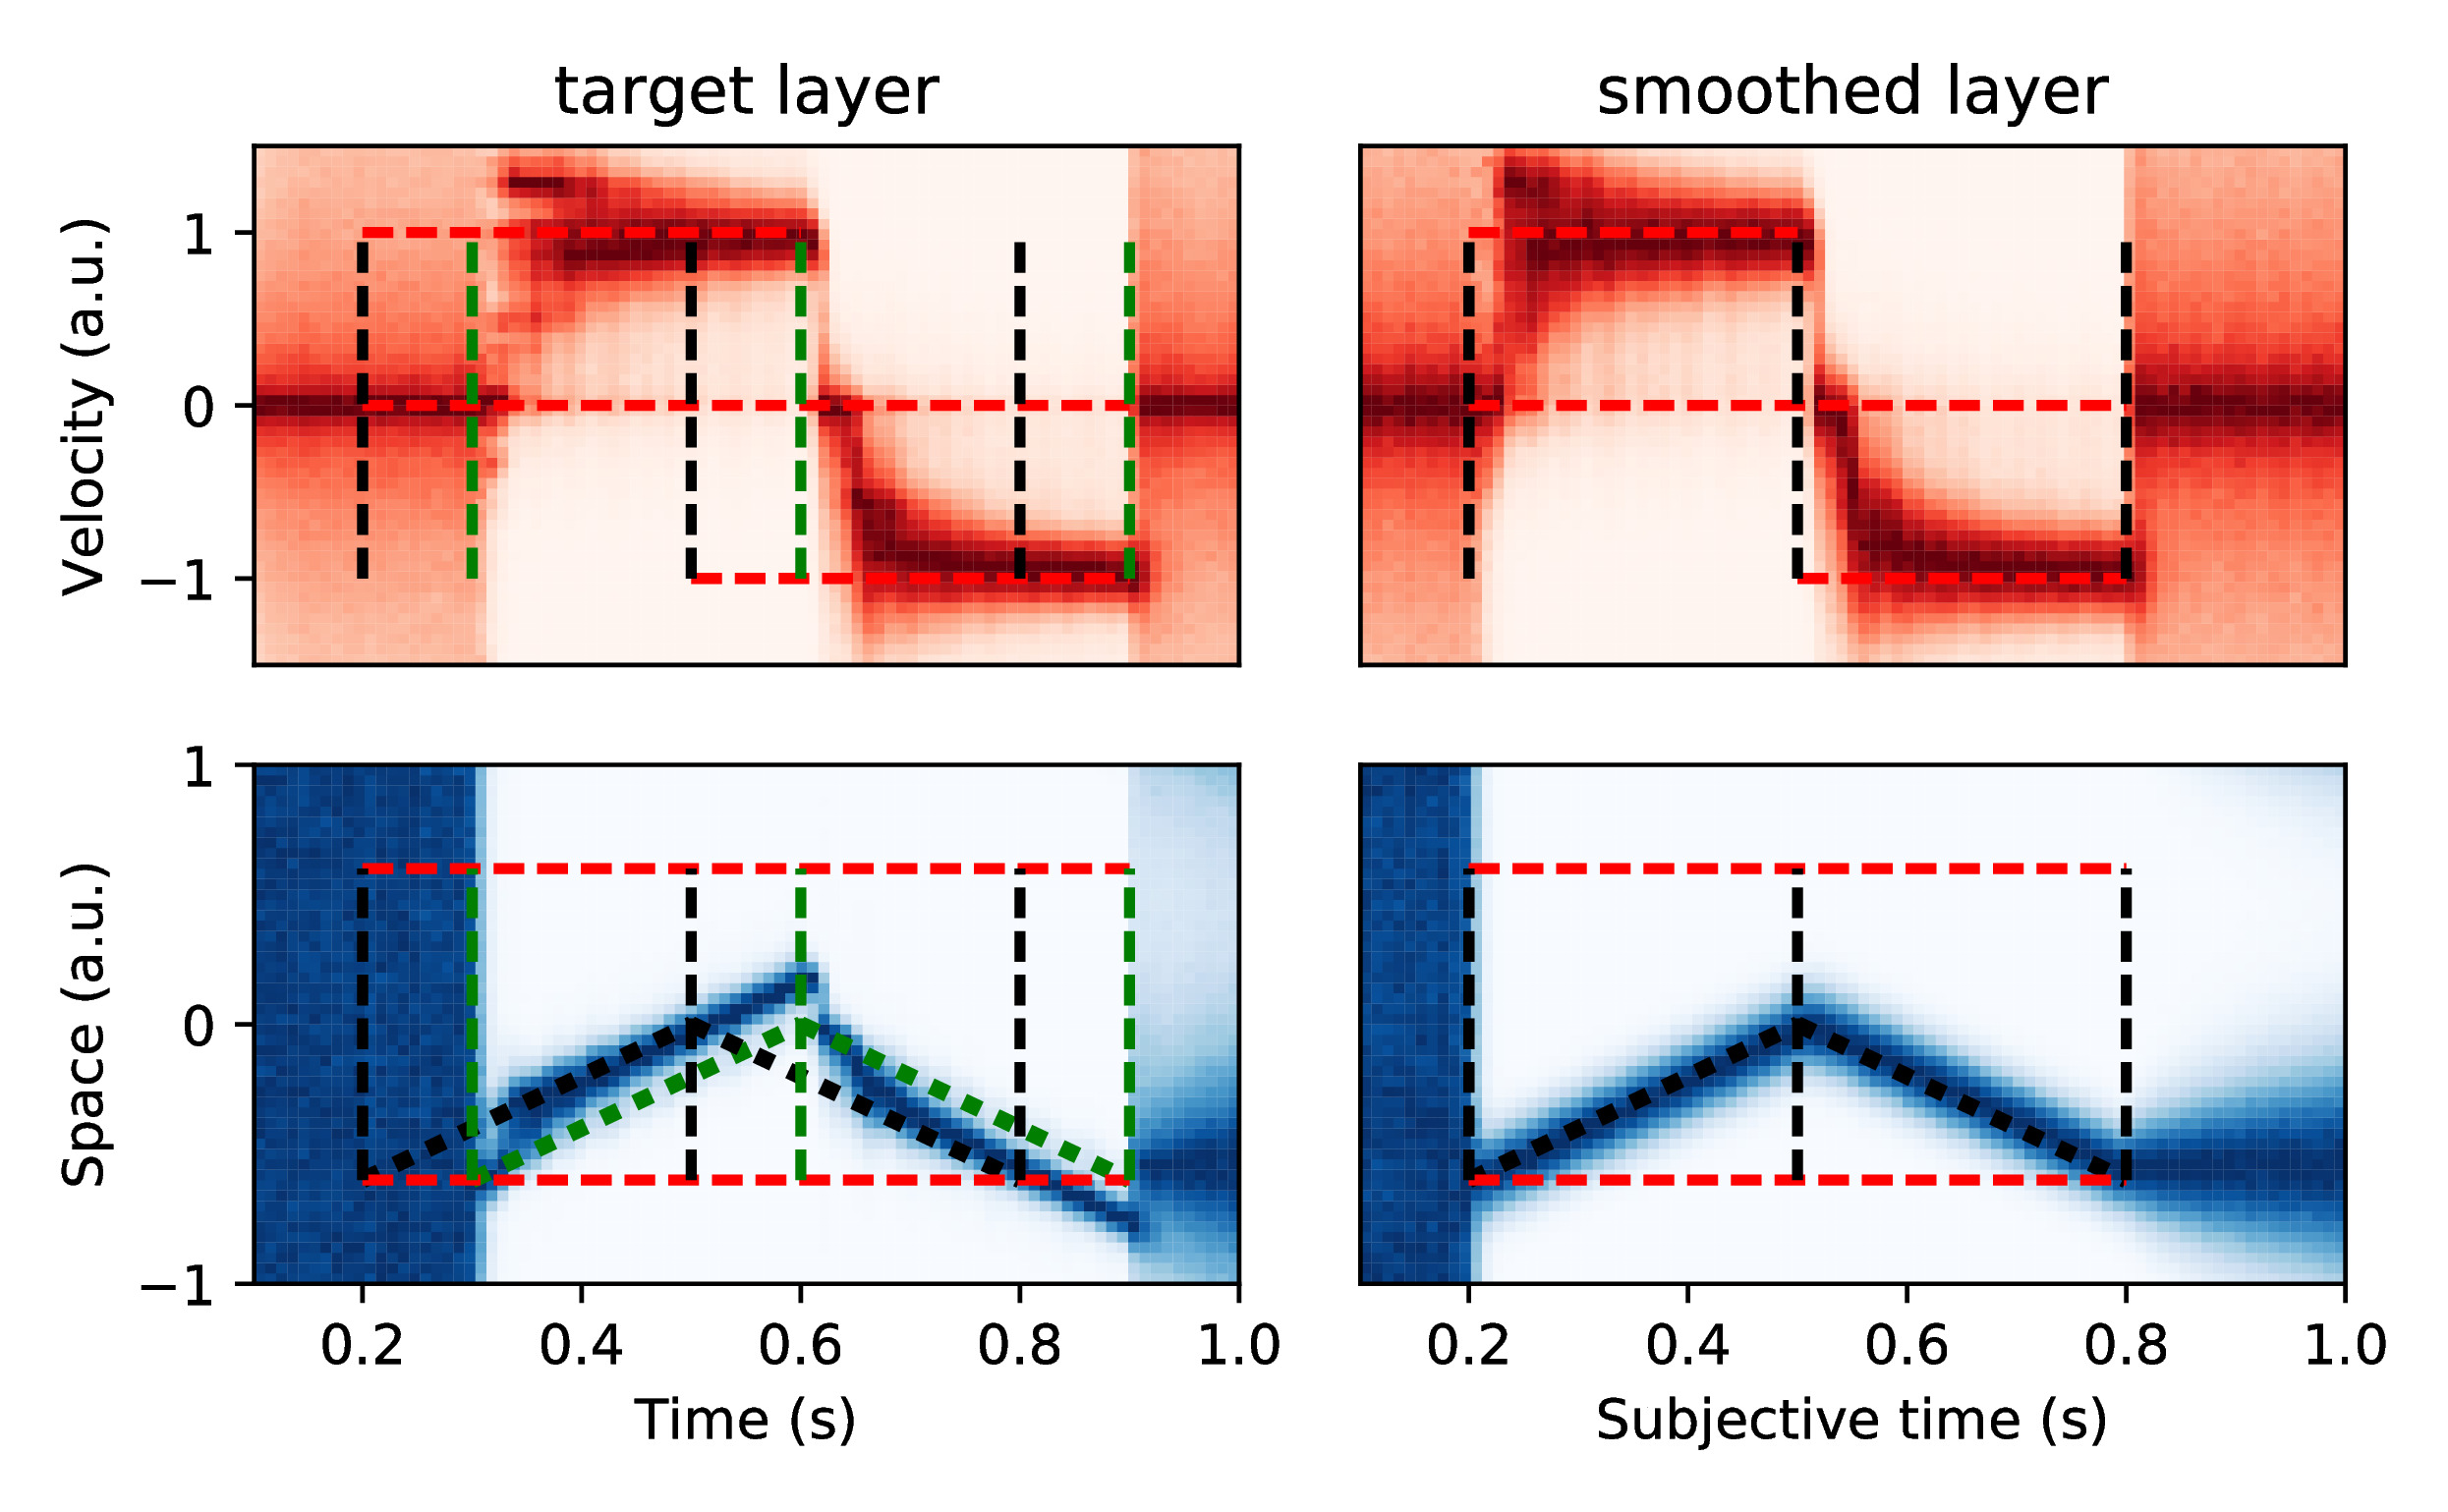

In [15]:
!convert -density 400 ../figures/FLE_MotionReversal.pdf ../figures/FLE_MotionReversal.jpg
!convert  -density 600 -units pixelsperinch -flatten  -compress lzw  -depth 8 ../figures/FLE_MotionReversal.pdf ../figures/FLE_MotionReversal.tiff

from IPython.display import Image
Image('../figures/FLE_MotionReversal.jpg')

In [16]:
!identify ../figures/FLE_MotionReversal.tiff

../figures/FLE_MotionReversal.tiff TIFF 3736x2309 3736x2309+0+0 8-bit sRGB 1.221MB 0.000u 0:00.000


## version control

In [17]:
#!git add experiment_MotionReversal.py figure_6_MotionReversal.ipynb ../figures/FLE_MotionReversal*
!git status

On branch master
Your branch is ahead of 'origin/master' by 7 commits.
  (use "git push" to publish your local commits)
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   default_param.py
	new file:   experiment_MotionReversal.py
	new file:   experiment_SI_controls.py
	new file:   experiment_contrast.py
	new file:   experiment_fle.py
	new file:   experiment_speed.py

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../.gitignore
	modified:   ../figures/FLE-A.pdf
	modified:   ../figures/FLE-A.png
	modified:   ../figures/FLE-B.pdf
	modified:   ../figures/FLE-B.png
	modified:   ../figures/FLE_MotionReversal.jpg
	modified:   ../figures/FLE_MotionReversal.pdf
	modified:   ../figures/FLE_MotionReversal.png
	modified:   ../figures/FLE_MotionReversal.tiff
	modified:   ../figures/FLE_MotionReversal_MBP.jpg
	modified:   ../figures/

In [18]:
!git commit -m' figure FLE : experiment_MotionReversal '   experiment_MotionReversal.py ../notebooks/figure_6_MotionReversal.ipynb ../figures/FLE_MotionReversal* ../khoei17fle.tex  
!#git push

[master 9dee95b]  figure FLE : experiment_MotionReversal
 10 files changed, 809 insertions(+), 701 deletions(-)
 rewrite figures/FLE_MotionReversal.jpg (89%)
 rewrite figures/FLE_MotionReversal.pdf (91%)
 rewrite figures/FLE_MotionReversal.png (99%)
 rewrite figures/FLE_MotionReversal.tiff (83%)
 rewrite figures/FLE_MotionReversal_MBP.jpg (89%)
 rewrite figures/FLE_MotionReversal_MBP.pdf (92%)
 rewrite figures/FLE_MotionReversal_MBP.png (98%)
 rewrite figures/FLE_MotionReversal_MBP.tiff (84%)
 rewrite notebooks/figure_6_MotionReversal.ipynb (83%)
 create mode 100644 scripts/experiment_MotionReversal.py
